In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import cv2 as cv
from galaxy2galaxy import problems
import tensorflow as tf

tf.enable_eager_execution()

%matplotlib inline
np.seterr(divide='ignore', invalid='ignore')

tf.version.VERSION

'1.15.0'

In [2]:
tf.executing_eagerly()

True

In [3]:
sigma_noise = 23.59

def pre_proc_unet(dico):
    r"""Preprocess the data and apply the Tikhonov filter on the input galaxy images.

    This function takes the dictionnary of galaxy images and PSF for the input and
    the target and returns a list containing 2 arrays: an array of galaxy images that
    are the output of the Tikhonov filter and an array of target galaxy images.

    Parameters
    ----------
    dico : dictionnary
        Array_like means all those objects -- lists, nested lists, etc. --
        that can be converted to an array.  We can also refer to
        variables like `var1`.
     
    Returns
    -------
    list
        list containing 2 arrays: an array of galaxy images that are the output of the
        Tikhonov filter and an array of target galaxy images.
    
    Example
    -------
    These are written in doctest format, and should illustrate how to
    use the function.

    >>> from galaxy2galaxy import problems # to list avaible problems run problems.available()
    >>> problem128 = problems.problem('attrs2img_cosmos_hst2euclide')
    >>> dset = problem128.dataset(Modes.TRAIN, data_dir='attrs2img_cosmos_hst2euclide')
    >>> dset = dset.map(pre_proc_unet)
    """
    # Add noise
    # For the estimation of CFHT noise standard deviation check section 3 of:
    # https://github.com/CosmoStat/ShapeDeconv/blob/master/data/CFHT/HST2CFHT.ipynb
    
    sigma_cfht = sigma_noise
    noise = tf.random_normal(shape=tf.shape(dico['inputs']), 
                             mean=0.0, 
                             stddev= sigma_cfht,
                             dtype=tf.float32) 
    
    dico['inputs'] = dico['targets'] + noise
    dico['targets'] /= 4000
    dico['inputs'] /= 4000

    return dico['inputs'], dico['targets'], dico['flux_radius']

### Loading Galaxy Images

In [4]:
with tf.compat.v1.Session() as sess:
    
    # Let's create an instance of the hsc_problem
    Modes = tf.estimator.ModeKeys
    problem128 = problems.problem('attrs2img_cosmos_parametric_cfht2hst')
    dset = problem128.dataset(Modes.EVAL, data_dir='/local/home/ua264756/Data/attrs2img_cosmos_parametric_cfht2hst')
    dset = dset.repeat()
    dset = dset.map(pre_proc_unet)
    n_batch = 128
    dset = dset.batch(n_batch)

    # Build an iterator over the dataset
    iterator = dset.make_one_shot_iterator().get_next()

    # Initialize batch
    batch = sess.run(iterator)


INFO:tensorflow:Reading data files from /local/home/ua264756/Data/attrs2img_cosmos_parametric_cfht2hst/attrs2img_cosmos_parametric_cfht2hst-dev*
INFO:tensorflow:partition: 0 num_data_files: 2

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.


Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


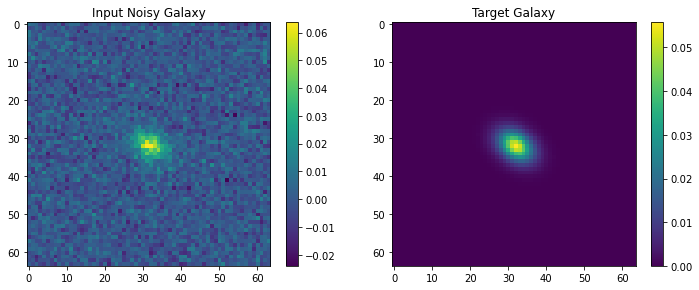

0.0061319843


In [5]:
ind_val = 4  # Corresponding ground truth & PSF in a batch

gal_input = np.squeeze(batch[0][ind_val])
gal_target = np.squeeze(batch[1][ind_val])

plt.figure(figsize=(12,12))
plt.subplot(121)
plt.imshow(gal_input)
plt.title("Input Noisy Galaxy")
plt.colorbar(shrink=0.375)

plt.subplot(122)
plt.imshow(gal_target)
plt.title("Target Galaxy")
plt.colorbar(shrink=0.375)

plt.show()

sigma_est = np.std(gal_input[0:20, 0:20])
print(sigma_est)

### Load Trained U-Net Model

In [6]:
model_1 = tf.keras.models.load_model('UNet_Denoiser/Models/UNet_param_ep{10}spe{6250}nb{32}', compile=False)
model_2 = tf.keras.models.load_model('UNet_Denoiser/Models/UNet_param_ep{10}spe{625}nb{128}', compile=False)

### 

# Input Ground Truth Images to U-Net

### Model 1

0.053966075


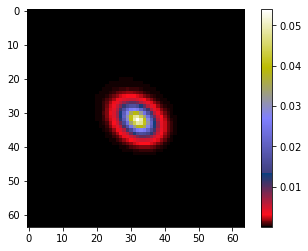

0.051828012


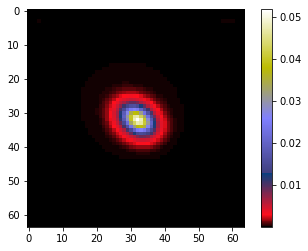

0.049994946


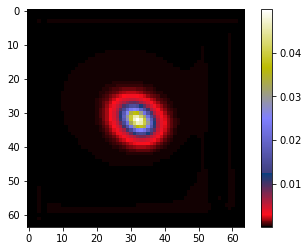

0.048631728


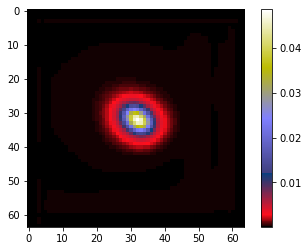

0.047557913


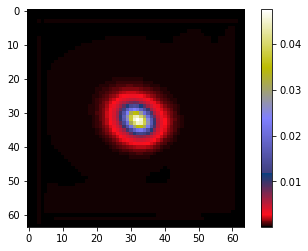

0.04666376


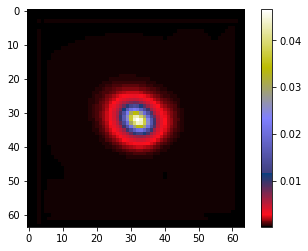

0.04588061


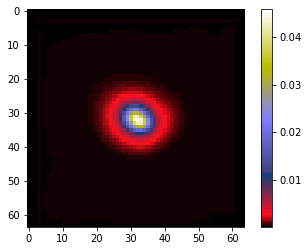

0.045168325


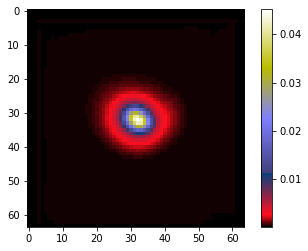

0.044495005


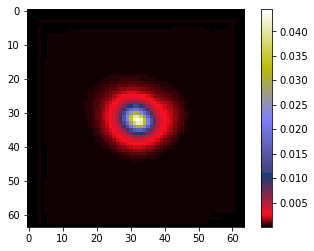

0.04383516


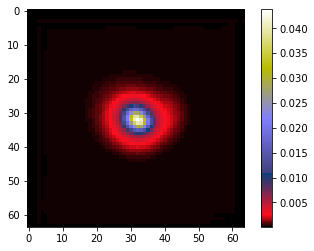

0.043161154


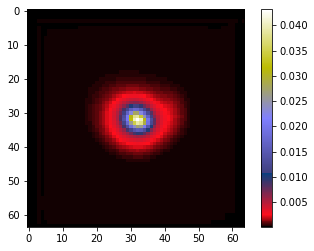

0.042453244


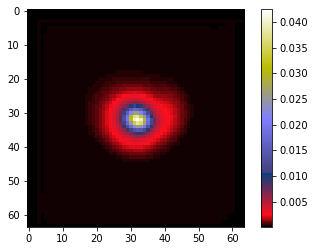

0.041689396


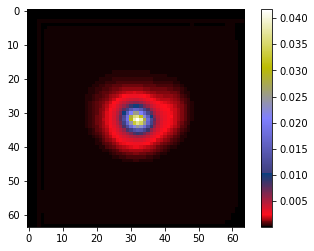

0.04086067


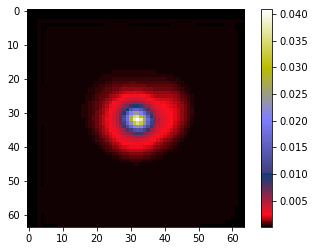

0.03994228


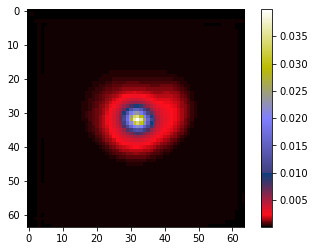

0.038864397


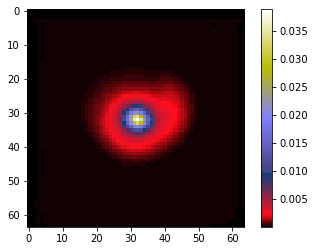

0.037665993


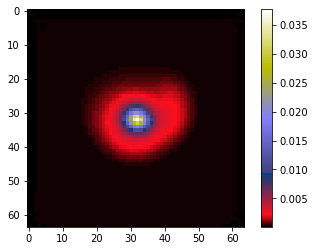

0.03630925


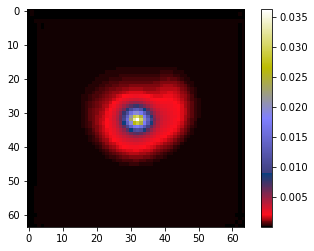

0.03454475


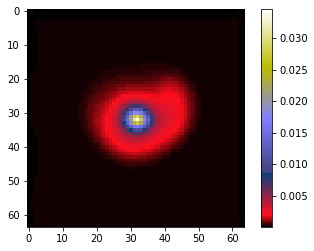

0.03226346


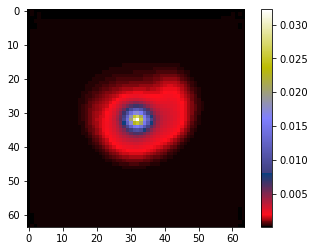

In [7]:
test = np.copy(gal_target)

for i in range(20):
    
    test = np.expand_dims(np.expand_dims(test, axis=0), axis=-1)
    test = np.squeeze(model_1(test))
    plt.imshow(test, cmap='gist_stern')
    plt.colorbar()
    print(np.max(test))
    plt.show()

### Model 2

0.070798226


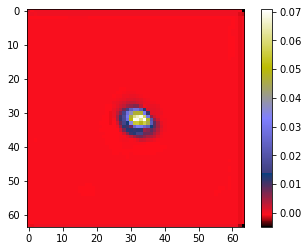

0.08349339


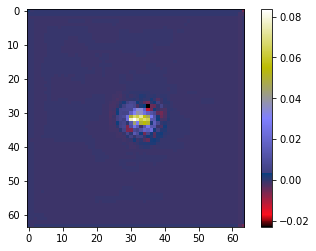

0.08427278


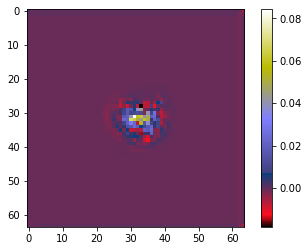

0.10333834


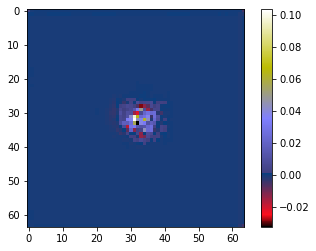

0.12443069


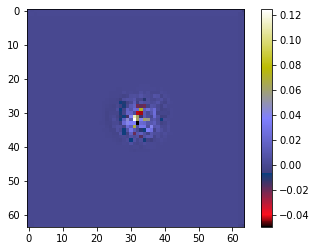

0.1714867


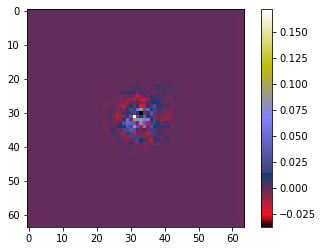

0.2631776


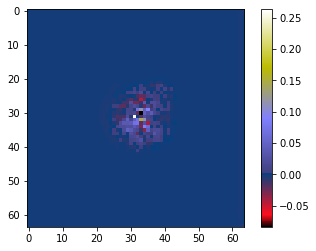

0.39785376


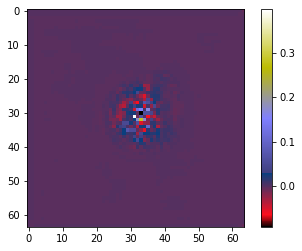

0.4739183


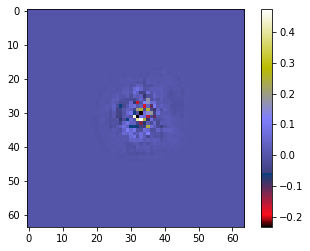

1.0065266


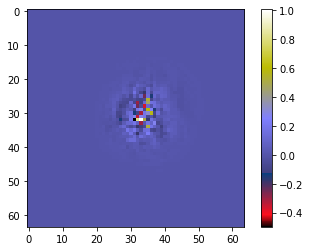

2.056236


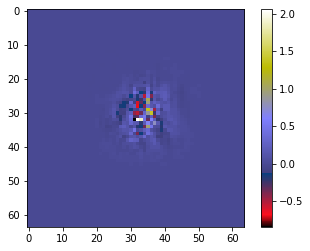

4.205365


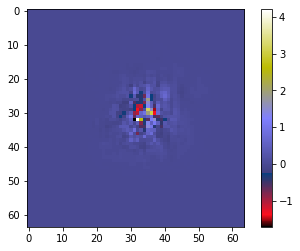

6.5739985


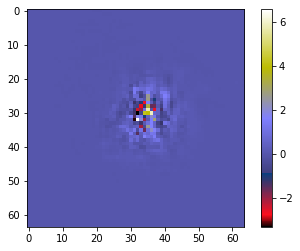

10.403817


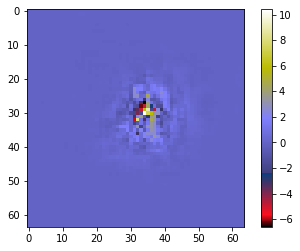

18.980309


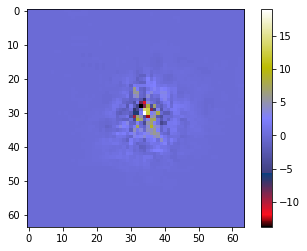

32.871742


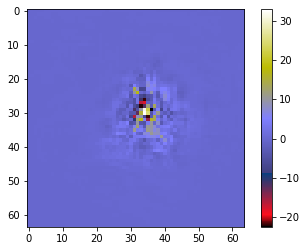

58.670937


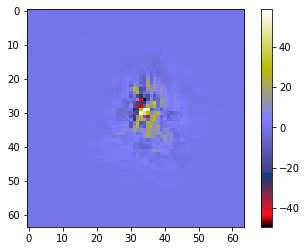

141.57741


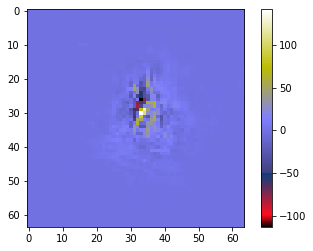

352.96884


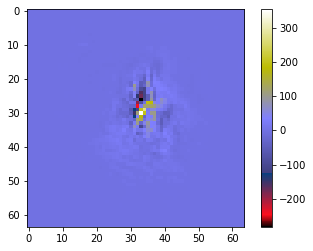

777.8347


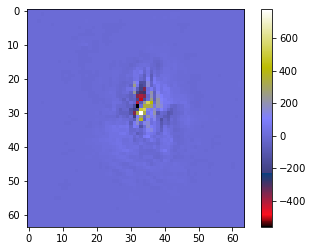

In [8]:
test = np.copy(gal_target)

for i in range(20):
    
    test = np.expand_dims(np.expand_dims(test, axis=0), axis=-1)
    test = np.squeeze(model_2(test))
    plt.imshow(test, cmap='gist_stern')
    plt.colorbar()
    print(np.max(test))
    plt.show()